In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from bcg_code import *

from IPython.display import clear_output

In [2]:
experiments = []

Λ = np.load('matrices/fastdecay.npy')
d = len(Λ)
l = 10

b = np.ones(d)/np.sqrt(d)

experiments.append({'name':'fastdecay', 'Λ':Λ, 'b':b, 'ts':np.arange(0,51,1,dtype='int'), 'reorth':True, 'l':l, 'μs':[0]})


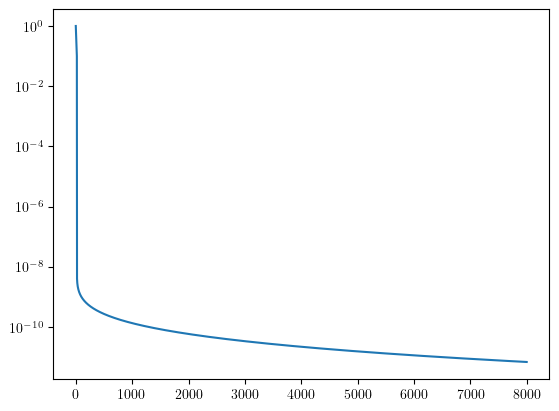

In [3]:
plt.plot(Λ)
plt.yscale('log')

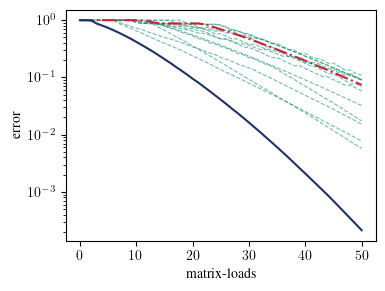

In [4]:
for experiment in experiments:

    name = experiment['name']
    Λ = experiment['Λ']
    b = experiment['b']
    ts = experiment['ts']
    reorth = experiment['reorth']
    l = experiment['l']
    μs = experiment['μs']

    d = len(Λ)
    A = sp.sparse.spdiags(Λ.reshape(1,d),[0])
    x_true = np.diag(1/Λ)@b

    μ = μs[0]
    x_true = (1/(Λ+μ))*b
    
    # CG
    x_CG = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth)
    err_CG = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_CG[i,0]
        err_CG[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)


    # nystrom PCG
    ss = [1,5,11]
    np.random.seed(0)
    Ω = np.random.randn(d,l)
    θs = np.hstack([[-1],np.geomspace(1e-9,1e-4,3)])
    
    err_PCG = np.full((len(ts),len(ss),len(θs)),np.nan)
    for si,s in enumerate(ss):
        for θi,θ in enumerate(θs):
            U,D = nystrom(A,Ω,s)

            if θ == -1:
                θ = D[-1]
                
            Aμ = A + μ*sp.sparse.eye(d)
            Pμ = deflation_precond12(U,D,θ,μ)
        
            x_PCG = get_PCG_sols(Aμ,b.reshape(d,1),Pμ,ts,reorth=reorth)
            for i,t in enumerate(ts):
                e = x_true-x_PCG[i]
                err_PCG[i,si,θi] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)

        
    # block CG
    B = np.hstack([b.reshape(d,1),Ω])
        
    x_BCG = get_BCG_sols(A,B,ts,μs,reorth=reorth)
    err_BCG = np.full(len(ts),np.nan)
    for i,t in enumerate(ts):
        e = x_true-x_BCG[i,0]
        err_BCG[i] = np.linalg.norm(Λ**.5*e)/np.linalg.norm(Λ**.5*x_true)


    fig,ax = plt.subplots(1,1,figsize=(4,3))
    for si,s in enumerate(ss):
        for θi,θ in enumerate(θs):
            mask = ts <= max(ts)-s-1
            if si==0 and θi==0:
                plt.plot(ts[mask]+s+1,err_PCG[mask,si,θi],ls='--',lw=.8,color=c3,alpha=.6,label='PCG')
            else:
                plt.plot(ts[mask]+s+1,err_PCG[mask,si,θi],ls='--',lw=.8,color=c3,alpha=.6)


    plt.plot(ts,err_CG,ls='-.',color=c2,label='CG')
    plt.plot(ts,err_BCG,ls='-',color=c1,label='BCG')

    plt.ylabel('error')
    plt.xticks(range(0,51,10))
    plt.xlabel(f'matrix-loads')

    # plt.subplots_adjust(left=.2)
    
    plt.yscale('log')

    plt.savefig(f"imgs/intro.pdf",bbox_inches='tight')

    # plt.close()

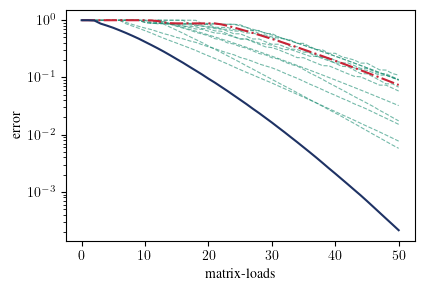

In [5]:
fig,ax = plt.subplots(1,1,figsize=(4.5,3))
for si,s in enumerate(ss):
    for θi,θ in enumerate(θs):
        mask = ts <= max(ts)-s-1
        if si==0 and θi==0:
            plt.plot(ts[mask]+s+1,err_PCG[mask,si,θi],ls='--',lw=.8,color=c3,alpha=.6,label='PCG')
        else:
            plt.plot(ts[mask]+s+1,err_PCG[mask,si,θi],ls='--',lw=.8,color=c3,alpha=.6)


plt.plot(ts,err_CG,ls='-.',color=c2,label='CG')
plt.plot(ts,err_BCG,ls='-',color=c1,label='BCG')

plt.ylabel('error')
plt.xticks(range(0,51,10))
plt.xlabel(f'matrix-loads')

# plt.subplots_adjust(left=.2)

plt.yscale('log')

plt.savefig(f"imgs/intro.pdf",bbox_inches='tight')